### Pipeline

1) Generating images
2) Generating text images with empty background
3) Combining images with texts using replicate
4) Combining new images into a video using shot stack


In [ ]:
!pip install -q transformers accelerate torch
!pip install -q diffusers==0.31.0 safetensors accelerate
!nvidia-smi || true
!pip install pillow
!pip install sacremoses
!pip install replicate

# Install system fonts
!sudo apt -y update >/dev/null
!sudo apt -y install fonts-dejavu fonts-freefont-ttf fonts-noto-core >/dev/null
!wget -q https://github.com/google/fonts/raw/main/ofl/lobster/Lobster-Regular.ttf -O /usr/share/fonts/truetype/lobster.ttf
!wget -q https://github.com/google/fonts/raw/main/ofl/montserrat/Montserrat-Bold.ttf -O /usr/share/fonts/truetype/montserrat-bold.ttf
!fc-cache -f

# Install additional fonts
!apt-get -y update -qq
!apt-get -y install -qq fonts-dejavu fonts-dejavu-core fonts-dejavu-extra fonts-freefont-ttf fonts-noto-core
!fc-cache -f

import re, torch, os, random, glob, unicodedata as ud
import asyncio
import replicate
import requests
import json
import gc
from typing import List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from uuid import UUID, uuid4

Tue Dec  2 13:12:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             29W /   70W |    9110MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
os.environ["REPLICATE_API_TOKEN"] = "x"
os.environ["SHOT_STACK_API_TOKEN"] = "y"

# If running in kaggle with secrets
# from kaggle_secrets import UserSecretsClient

# os.environ["REPLICATE_API_TOKEN"] = UserSecretsClient().get_secret("REPLICATE_API_TOKEN")
# os.environ["SHOT_STACK_API_TOKEN"] = UserSecretsClient().get_secret("SHOT_STACK_API_TOKEN")


In [ ]:
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE    = torch.float16 if DEVICE == "cuda" else torch.float32
W, H     = 512, 512
LORA_DIR = "/content"
WT_NAME  = "pytorch_lora_weights.safetensors"
BASE     = "Manojb/stable-diffusion-2-1-base"

# Number of images and text overlays to generate (must match)
NUM_ITEMS = 3

ruen_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ruen_mt  = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(DEVICE).eval()

@torch.inference_mode()
def ru2en(text: str) -> str:
    enc = ruen_tok(text.strip(), return_tensors="pt").to(DEVICE)
    out = ruen_mt.generate(**enc, max_new_tokens=64)
    return ruen_tok.batch_decode(out, skip_special_tokens=True)[0].strip()

CYR = re.compile(r"[А-Яа-яЁё]")
def to_english(s: str) -> str:
    return ru2en(s) if CYR.search(s) else s.strip()

q_model_id = "Qwen/Qwen2.5-1.5B-Instruct"
q_tok = AutoTokenizer.from_pretrained(q_model_id)
q_llm = AutoModelForCausalLM.from_pretrained(q_model_id, torch_dtype=DTYPE).to(DEVICE).eval()

def build_system_prompt(num_prompts: int) -> str:
    """
    Build system prompt for generating Stable Diffusion prompts.

    Args:
        num_prompts: Number of prompts to generate

    Returns:
        System prompt string
    """
    return (
        f"You rewrite a short holiday/topic into {num_prompts} concise Stable Diffusion XL prompts for a festive POSTCARD.\n"
        "- Keep each line concrete and short (<= 48 words).\n"
        "- Focus on specific subjects and simple composition (what/where/background).\n"
        "- Allowed: pastel background, soft bokeh, glitter sparkles, glossy highlights, photomontage postcard style.\n"
        "- Must include: 'postcard, no text'.\n"
        "- FORBIDDEN: masterpiece, 8k, absurdres, by <artist>, nsfw, anatomy, camera brands, friends, family, group, people, girl, boy, man, woman\n"
        "- Avoid winter/snow/Christmas motifs unless the topic explicitly mentions them.\n"
        f"- Output exactly {num_prompts} lines, no numbering."
    )

EXAMPLES = (
    "Examples:\n"
    "Valentine's Day -> picture of two kittens sitting inside a big pink heart, sparkles and roses, pastel background, no text\n"
    "International Women's Day -> pink roses and satin ribbon arranged neatly, pastel gradient background, soft bokeh, postcard, no text\n"
    "Easter -> yellow chick emerging from decorated egg shell, surrounded by spring flowers, pastel pink and green background, glitter sparkles, glossy highlights, photomontage postcard style, no humans, no text\n"
    "Christmas -> white dove flying over red roses, glowing sunset, sparkles, high saturation, no text\n"
)

def normalize_topic(en_text: str) -> str:
    t = en_text.strip().lower()
    if t in {"8 march", "march 8", "8th march"}:
        return "International Women's Day"
    return en_text.strip()

def build_chat_inputs(topic_en: str, num_prompts: int):
    """
    Build chat inputs for LLM to generate prompts.

    Args:
        topic_en: Topic in English
        num_prompts: Number of prompts to generate

    Returns:
        Encoded inputs for the LLM
    """
    system_prompt = build_system_prompt(num_prompts)
    messages = [
        {"role": "system", "content": system_prompt + "\n" + EXAMPLES},
        {"role": "user",   "content": f"Topic: {topic_en}\nReturn {num_prompts} lines, one per prompt."}
    ]

    prompt_text = q_tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    enc = q_tok(prompt_text, return_tensors="pt", padding=True).to(DEVICE)
    return enc

BLACK = [
    r"\bmasterpiece\b", r"\b8k\b", r"\babsurdres\b",
    r"\b(anatomy|nsfw)\b", r"\bby\s+[A-Z][a-z]+\b", r"\bdslr\b"
]

def sanitize_line(line: str, max_words=48) -> str:
    t = line.strip()
    t = re.sub(r"^\s*\d+\s*[\.\)\-:]\s*", "", t)
    for patt in BLACK:
        t = re.sub(patt, "", t, flags=re.IGNORECASE)
    t = re.sub(r"\s*,\s*", ", ", t)
    t = re.sub(r"(,\s*){2,}", ", ", t).strip(" ,")
    low = t.lower()
    if "postcard" not in low: t += ", postcard"
    if "no text" not in low:  t += ", no text"
    words = t.split()
    if len(words) > max_words: t = " ".join(words[:max_words])
    return t

@torch.inference_mode()
def make_prompts(user_text: str, num_prompts: int = 3, temperature=0.2) -> dict:
    """
    Generate Stable Diffusion prompts for a given topic.

    Args:
        user_text: User input topic (can be in Russian or English)
        num_prompts: Number of prompts to generate (default: 5)
        temperature: Sampling temperature for LLM generation (default: 0.2)

    Returns:
        Dictionary with keys:
            - topic_en: Normalized topic in English
            - prompts: List of generated prompts
            - negative: Negative prompt for Stable Diffusion
    """
    topic_en = normalize_topic(to_english(user_text))
    enc = build_chat_inputs(topic_en, num_prompts)
    out = q_llm.generate(
        **enc, max_new_tokens=200, do_sample=True, temperature=temperature,
        top_p=0.8, repetition_penalty=1.05,
        eos_token_id=q_tok.eos_token_id, pad_token_id=q_tok.eos_token_id
    )
    raw = q_tok.decode(out[0, enc["input_ids"].shape[-1]:], skip_special_tokens=True)
    lines = [s.strip() for s in raw.splitlines() if s.strip()]
    # Ensure we have exactly num_prompts lines
    lines = lines[:num_prompts] if len(lines) >= num_prompts else (lines + [""]*(num_prompts-len(lines)))
    clean = [sanitize_line(l) if l else
             "festive postcard scene with fitting symbols, pastel background, soft bokeh, glitter sparkles, postcard, no text"
             for l in lines]
    neg = "text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, people, bad anatomy"
    return {"topic_en": topic_en, "prompts": clean, "negative": neg}



pipe = StableDiffusionPipeline.from_pretrained(
    BASE, torch_dtype=torch.float16
).to(DEVICE)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


pipe.enable_attention_slicing()
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

# Load LoRA weights
pipe.load_lora_weights(LORA_DIR, weight_name=WT_NAME)


def gen(prompt: str, outfile: str, negative: str,
        steps=24, cfg=6.2, w=512, h=512, seed=1234):
    g = torch.Generator(device=DEVICE).manual_seed(seed)
    image = pipe(
        prompt=prompt, negative_prompt=negative,
        num_inference_steps=steps, guidance_scale=cfg,
        width=w, height=h, generator=g
    ).images[0]
    image.save(outfile)
    return image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

EN topic: New Year
Prompt 1: New Year's Eve fireworks display, neon lights, glitter sparkles, soft bokeh, postcard, no text
Prompt 2: Snowflakes falling gently, peaceful winter landscape, pastel background, glossy highlights, photomontage postcard style, no text
Prompt 3: Clock striking midnight, candles lit, festive decorations, soft bokeh, postcard, no text
NEG: text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, people, bad anatomy


  0%|          | 0/24 [00:00<?, ?it/s]

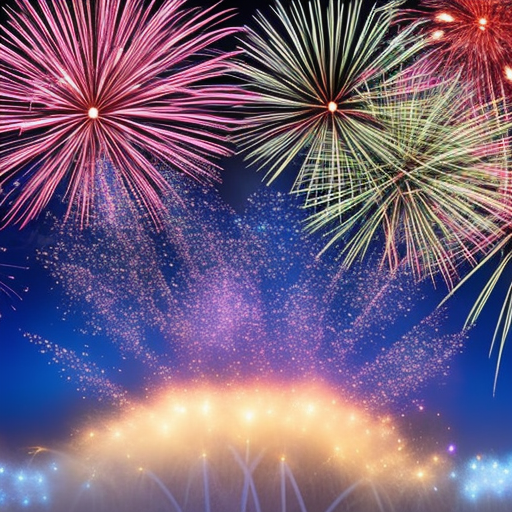

  0%|          | 0/24 [00:00<?, ?it/s]

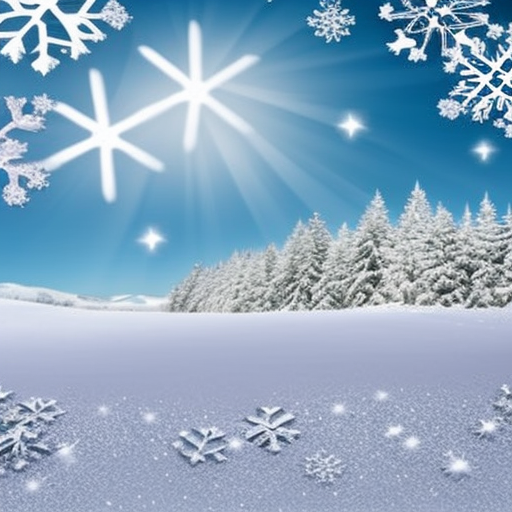

  0%|          | 0/24 [00:00<?, ?it/s]

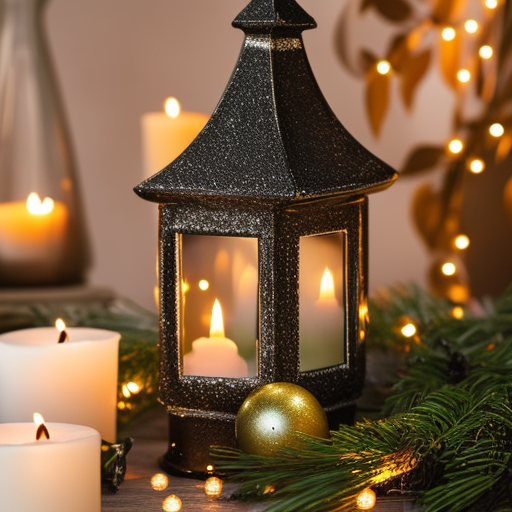

In [ ]:
# Generate images from prompts
INPUT_PATH = "/content/resources/"
# Create resources directory if it doesn't exist
os.makedirs(INPUT_PATH, exist_ok=True)

user_text = "Новый год"  # Can be replaced with input() for interactive use

# Generate prompts for the topic
pack = make_prompts(user_text, num_prompts=NUM_ITEMS)
print("EN topic:", pack["topic_en"])
for i, p in enumerate(pack["prompts"], 1):
    print(f"Prompt {i}: {p}")
print("NEG:", pack["negative"])

imgs = []
image_filenames = []
for i, p in enumerate(pack["prompts"], 1):
    try:
        file_name = INPUT_PATH + uuid4().hex + ".png"
        img = gen(p, file_name, negative=pack["negative"], seed=1000+i)
        image_filenames.append(file_name)
        imgs.append(img); display(img)
    except Exception as e:
        print(e)

In [ ]:
# Texts

MODEL_NAME = os.environ.get("SLOGAN_LLM", "Qwen/Qwen2.5-1.5B-Instruct")
K_OUT      = 3
SEED       = 23
BG_DEFAULT = "transparent"      # "transparent" | "white"
PALETTE    = [(231,76,60),(46,204,113),(52,152,219),(155,89,182),(241,196,15),(50,29,88)]


SAFE_FAMILIES = ("DejaVuSans", "NotoSans")

random.seed(SEED); torch.manual_seed(SEED)

def collect_fonts() -> list[Path]:
    roots = ("/usr/share/fonts", "/usr/local/share/fonts")
    keep = []
    for d in roots:
        keep += [Path(p) for p in glob.glob(os.path.join(d, "**", "DejaVuSans*.ttf"), recursive=True)]
        keep += [Path(p) for p in glob.glob(os.path.join(d, "**", "NotoSans*.ttf"),   recursive=True)]
    order = {"DejaVuSans.ttf":0, "DejaVuSans-Bold.ttf":1, "DejaVuSans-Oblique.ttf":2,
             "NotoSans-Regular.ttf":3, "NotoSans-Bold.ttf":4, "NotoSans-Italic.ttf":5}
    keep = [p for p in keep if p.exists()]
    keep.sort(key=lambda p: (order.get(p.name, 99), p.name))
    return keep


def font_supports_text(font_path: Path, text: str) -> bool:
    try:
        f = ImageFont.truetype(str(font_path), size=28)
    except Exception:
        return False
    for ch in text:
        if ch in " -":
            continue
        try:
            bbox = f.getbbox(ch)
        except Exception:
            try:
                w,h = f.getsize(ch); bbox = (0,0,w,h)
            except Exception:
                return False
        if not bbox or (bbox[2]-bbox[0]) <= 0 or (bbox[3]-bbox[1]) <= 0:
            return False
    return True

def load_llm():
    tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, torch_dtype=DTYPE, device_map="auto", trust_remote_code=True
    )
    return tok, model

def detect_lang(text: str) -> str:
    return "ru" if re.search(r"[\u0400-\u04FF]", text) else "en"

def sanitize(text: str, lang: str) -> str:
    t = ud.normalize("NFKC", text)
    t = t.replace("\u00A0", " ").replace("\u2009", " ").replace("\u202F", " ")
    t = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    allow = r"[^\u0400-\u04FF0-9\- ]" if lang == "ru" else r"[^A-Za-z0-9\- ]"
    t = re.sub(allow, "", t)
    t = re.sub(r"\s+", " ", t).strip()
    if re.search(r"\d{4}", t):
        t = re.sub(r"\d{4}", "", t).strip()
    return t

def gen_phrases(topic: str, lang: str, k: int) -> list[str]:
    tok, model = load_llm()
    RX = re.compile(r"^[\u0400-\u04FF0-9\- ]{1,40}$") if lang=="ru" else re.compile(r"^[A-Za-z0-9\- ]{1,40}$")

    examples = {
        "ru": """
                Примеры
                новый год: С Новым годом, Счастливого Нового года, Поздравляем с НГ,
                Рождество: С Рождеством Христовым, Светлого Рождества, Рождественских чудес,
                8 марта: С восьмым марта, Международный женский день, Ты у меня самая дорогая
                """,
        "en": """
                Examples
                New Year: Happy New Year, New Year Wishes, New Year New life,
                christmas: Merry Christmas, Bright Xmas, Happy 25th of December,
                8th of March: Happy eight of March, Women's international day, You're very sweet,
                generic: Congratulations, Best Wishes, Warm Regards
                """
    }
    script_rule = "Use only Cyrillic letters (А-Я, а-я) and numbers." if lang=="ru" else "Use only Latin letters (A–Z, a–z) and numbers."

    def ask_one() -> str:
        sys_prompt = (
            "You output ONE holiday wish (holiday specified by user) that might appear on a postcard. "
            f"Language: {lang}. One variant per line, no numbering. "
            "2 to 5 words. No punctuation, quotes, emoji, hashtags."
            + script_rule + "\n" + examples[lang]
        )
        user = f"Topic: {topic}\nReturn only the phrase on the first line. No explanations."
        if hasattr(tok, "apply_chat_template"):
            prompt = tok.apply_chat_template(
                [{"role":"system","content":sys_prompt},
                 {"role":"user","content":user}],
                tokenize=False, add_generation_prompt=True
            )
        else:
            prompt = sys_prompt + "\n" + user + "\nAssistant:\n"

        enc = tok(prompt, return_tensors="pt"); enc = {k:v.to(model.device) for k,v in enc.items()}
        out = model.generate(**enc, max_new_tokens=32, temperature=1.3, top_p=0.9,
                             do_sample=True, repetition_penalty=1.15,
                             eos_token_id=getattr(tok,"eos_token_id",None))
        new = out[0, enc["input_ids"].shape[1]:]
        raw = tok.decode(new, skip_special_tokens=True)
        s = raw.splitlines()[0].strip() or re.split(r"[,\uFF0C;]+", raw)[0].strip()
        s = ud.normalize("NFKC", s)
        s = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|#@$%&]", "", s)
        s = re.sub(r"\s+", " ", s).strip()
        s = re.sub(r"[^\u0400-\u04FF0-9\- ]","",s) if lang=="ru" else re.sub(r"[^A-Za-z0-9\- ]","",s)
        s = re.sub(r"\s+"," ",s).strip()
        return s


    res, seen, tries = [], set(), 0
    topic_norm = re.sub(r"\s+"," ", topic.lower()).strip()
    while len(res) < k and tries < k*5:
        tries += 1
        s = ask_one()
        if not s or not (2 <= len(s.split()) <= 5):
            continue
        if not RX.match(s):
            continue
        key = s.lower()
        if key == topic_norm or key in {"system","assistant","user","topic","response","output"}:
            continue
        if key in seen:
            continue

        seen.add(key); res.append(s)
    
    # Clean up model memory after generation
    del tok, model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return res


def fit_font(font_path: Path, text: str, draw: ImageDraw.ImageDraw, w: int, h: int):
    lo, hi, best = 14, 260, None
    while lo <= hi:
        mid = (lo + hi)//2
        try:
            f = ImageFont.truetype(str(font_path), size=mid)
        except Exception:
            f = ImageFont.load_default()
        x0,y0,x1,y1 = draw.textbbox((0,0), text, font=f)
        if (x1-x0) <= w and (y1-y0) <= h:
            best = f; lo = mid + 1
        else:
            hi = mid - 1
    return best or ImageFont.load_default()

def render_phrase(text: str, font_path: Path, color=(20,20,20), bg="transparent"):
    fonts = collect_fonts()
    use = next((p for p in fonts if p.name.endswith("Bold.ttf")), fonts[0])

    mode = "RGBA" if bg=="transparent" else "RGB"
    img  = Image.new(mode, (W,H), (0,0,0,0) if mode=="RGBA" else (255,255,255))
    draw = ImageDraw.Draw(img)
    font = fit_font(use, text, draw, W-60, H-40)
    x0,y0,x1,y1 = draw.textbbox((0,0), text, font=font)
    x,y = (W-(x1-x0))//2, (H-(y1-y0))//2
    stroke = (0,0,0,200) if mode=="RGBA" else (0,0,0)
    draw.text((x,y), text, font=font, fill=color, stroke_width=2, stroke_fill=stroke)

    file_name = uuid4().hex
    file_path = os.path.join(INPUT_PATH, file_name + '.png')
    img.save(file_path)
    return img, file_path


# main function
def generate_and_display(topic: str, lang: str="auto", bg: str=BG_DEFAULT, k: int=K_OUT):
    fonts = collect_fonts()
    if not fonts:
        raise SystemExit("No fonts found. Install DejaVu/Noto.")
    lang = detect_lang(topic) if lang=="auto" else lang

    phrases = gen_phrases(topic, lang, k)
    if len(phrases) < k:
        need = k #- len(phrases)
        extra = gen_phrases(topic + " variations", lang, need)
        for p in extra:
            phrases.append(p)
            if len(phrases) == k:
                break
    if not phrases:
        phrases = [sanitize(topic, lang)]

    base = next((p for p in fonts if "DejaVuSans" in p.name), fonts[0])
    alt  = next((p for p in fonts if "NotoSans"  in p.name), fonts[min(1, len(fonts)-1)])
    font_pool = [base, alt] + random.sample(fonts, k=min(3, len(fonts)))

    text_filenames = []
    for t in phrases[:k]:
        img, file_path = render_phrase(t, random.choice(font_pool), color=random.choice(PALETTE), bg=bg)
        display(img)
        text_filenames.append(file_path)
    return text_filenames, phrases[:k]

<>:64: SyntaxWarning: invalid escape sequence '\['
<>:107: SyntaxWarning: invalid escape sequence '\['
<>:64: SyntaxWarning: invalid escape sequence '\['
<>:107: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-1783893796.py:64: SyntaxWarning: invalid escape sequence '\['
  t = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", t)
/tmp/ipython-input-1783893796.py:107: SyntaxWarning: invalid escape sequence '\['
  s = re.sub(r"[\"""'«».,:;!?/\\()\[\]{}*_+=~^`|]", "", s)


In [ ]:
# Clear CUDA cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# Force garbage collection
gc.collect()
print("Memory cleanup completed")

text_filenames, text_phrases = generate_and_display(user_text, k=NUM_ITEMS)

NameError: name 'generate_and_display' is not defined

In [29]:
import os
import asyncio
from uuid import uuid4
import replicate

COMBINATION_PROMPT = (
    "Take the text from the second image and place it onto the first image."
    "Remove only the background behind the text from the second image, leaving the text itself completely unchanged."
    "Do NOT modify the shape, style, color, thickness, or appearance of the text in any way."
    "Use the original text exactly as it appears, only without its surrounding background."
    "You may place the text anywhere on the first image (top, bottom, or any suitable position)."
    "Do NOT add any new text."
    "The final result should look like a postcard my grandmother might send me."

)

# Initialize Replicate client using REPLICATE_API_TOKEN from environment
client = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])

MODEL_VERSION = "bytedance/seedream-4:3ee3b70df63b39e425ccb0188d3c14961177c11fa20516d9dfd30a868b41b2d5"


async def add_text_to_image(
    text_image_path: str,
    main_image_path: str,
    output_dir: str = "image_outputs",
    output_size: str = "1K",
    aspect_ratio: str = "1:1",
    save_locally: bool = True,
) -> tuple[str, str]:
    """
    Combine one main image with one text image (async version).

    Note: REPLICATE_API_TOKEN must be set in the environment.

    Args:
        text_image_path: Path to the text overlay image
        main_image_path: Path to the main background image
        output_dir: Directory to save the output image
        output_size: Output image size (e.g., "1K")
        aspect_ratio: Aspect ratio for the output (e.g., "1:1")
        save_locally: Whether to save the image locally

    Returns:
        Tuple of (URL string, local file path string)
    """
    # Upload images to Replicate (synchronous, but fast)
    with open(text_image_path, "rb") as f:
        text_image = client.files.create(f)

    with open(main_image_path, "rb") as f:
        main_image = client.files.create(f)

    input_data = {
        "size": output_size,
        "prompt": COMBINATION_PROMPT,
        "aspect_ratio": aspect_ratio,
        "image_input": [main_image.urls["get"], text_image.urls["get"]],
    }

    # Run model asynchronously
    output = await client.async_run(MODEL_VERSION, input=input_data)
    # Output is a list of URLs for the generated images
    url = str(output[0])

    local_filename = ""
    if save_locally:
        os.makedirs(output_dir, exist_ok=True)
        file_name = uuid4().hex + ".jpg"
        local_path = os.path.join(output_dir, file_name)

        # Download image using requests (synchronous; can be replaced with aiohttp if needed)
        import requests

        resp = requests.get(url)
        resp.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(resp.content)

        local_filename = local_path

    return url, local_filename


# Run image combination in parallel
results = await asyncio.gather(*[
    add_text_to_image(text_filenames[i], image_filenames[i], output_dir="image_outputs")
    for i in range(len(text_filenames))
])

images_with_text = [url for url, _ in results]
images_with_text_paths = [path for _, path in results]

print(f"Generated {len(images_with_text)} images")
print("URLs:", images_with_text)
print("Local paths:", images_with_text_paths)


Generated 3 images
URLs: ['https://replicate.delivery/xezq/2urt8CJyez3rGyXXGbRRabYNEffoi3jHP9lw5dOGofBhnm8WB/tmpwund7mxe.jpg', 'https://replicate.delivery/xezq/fHXIe7VkH1uHEEdgKcwpm7J8y3RNHYWH1F6ZViGc0rz6pJvVA/tmpzvtayti2.jpg', 'https://replicate.delivery/xezq/VbQMFbCmfnQBHKdneLFfYX8eeWuK8Na1MXIPix0BYvgJRN5tC/tmps9h8f536.jpg']
Local paths: ['image_outputs/cd34ebad27cd4c299f30c7f80363fd6f.jpg', 'image_outputs/107045d714c04f30948753649e1cc057.jpg', 'image_outputs/869448c01edf4c729ec57ed23456ad25.jpg']


In [19]:
images_with_text

['https://replicate.delivery/xezq/Ajf5ehxvgSluwkbfZp6wslVFH3RNynIABqU2IKAiUUVPGTeWB/tmpdpbh4usa.jpg',
 'https://replicate.delivery/xezq/GWwrEFYb65b8HpQM5C9lMAtCmfRv32fhJg5o3d8L65odjJvVA/tmpb0lp3ydy.jpg',
 'https://replicate.delivery/xezq/fFkKiEIgG6w5bSJtu9syKEe7yNdecvfHLD1ofcCz5rjtZM5tC/tmp4th85xk1.jpg',
 'https://replicate.delivery/xezq/iIJISHlvPWZGC1Gmx6SDOJAIxLRjIulcEaWv31Ma62m2YybF/tmpl8mnu03i.jpg',
 'https://replicate.delivery/xezq/f4yPD5wcokzsdiLtq641rNOiS0DHYcHB4B8QVAdAfsfMHTeWB/tmp9xunymgw.jpg']

In [20]:
# Combine images into a video
API_KEY = os.environ['SHOT_STACK_API_TOKEN']

# For production, use "https://api.shotstack.io/v1/render"
url = "https://api.shotstack.io/stage/render"
headers = {
    "x-api-key": API_KEY,
    "Content-Type": "application/json"
}

# Define transitions for video clips
transitions = [
    {"in": None, "out": "slideRight"},
    {"in": "wipeLeft", "out": "fade"},
    {"in": "slideUp", "out": "slideDown"},
    {"in": "slideUp", "out": "slideRight"},
    {"in": "slideUp", "out": "fade"},
]

# Build clips dynamically based on number of images
clip_length = 3  # Duration of each clip in seconds
clips = []
for i, img_url in enumerate(images_with_text):
    clip_data = {
        "asset": {"type": "image", "src": img_url},
        "start": i * clip_length,
        "length": clip_length,
    }
    # Add transitions (cycle through available transitions)
    transition = transitions[i % len(transitions)]
    if transition["in"]:
        clip_data["transition"] = {"in": transition["in"]}
    if transition["out"]:
        if "transition" not in clip_data:
            clip_data["transition"] = {}
        clip_data["transition"]["out"] = transition["out"]
    clips.append(clip_data)

# TODO: Change aspect_ratio if needed
payload = {
    "timeline": {
        "tracks": [
            {
                "clips": clips
            }
        ]
    },
    "output": {"format": "mp4", "resolution": "hd", "aspectRatio": "1:1"}
}

# Retry logic for API call
import time
max_retries = 5
retry_delay = 2  # seconds

response = None
for attempt in range(max_retries):
    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        # Check if request was successful (status code 200-299)
        if 200 <= response.status_code < 300:
            print(f"Request successful (attempt {attempt + 1}): {response.status_code}")
            print(response.text)
            break
        else:
            print(f"Attempt {attempt + 1} failed with status code {response.status_code}: {response.text}")
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed after {max_retries} attempts")
    except Exception as e:
        print(f"Attempt {attempt + 1} raised an exception: {e}")
        if attempt < max_retries - 1:
            print(f"Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        else:
            print(f"Failed after {max_retries} attempts")
            raise


Request successful (attempt 1): 201
{"success":true,"message":"Created","response":{"message":"Render Successfully Queued","id":"15ff1cd4-8c1b-4169-a088-b1ed1f2ef639"}}


In [ ]:
# Wait for render to complete before checking status
RENDER_ID = json.loads(response.text)['response']['id']

# For production, use f"https://api.shotstack.io/v1/render/{RENDER_ID}"
url = "https://api.shotstack.io/stage/render"

# Retry logic for GET request
import time
max_retries = 5
retry_delay = 2  # seconds

r = None
for attempt in range(max_retries):
    try:
        r = requests.get(url + f"/{RENDER_ID}", headers=headers)
        # Check if request was successful (status code 200-299)
        if 200 <= r.status_code < 300:
            response_data = r.json()
            # Check if response contains 'url' and status is 'done'
            if 'response' in response_data and 'url' in response_data['response']:
                status = response_data['response'].get('status', 'unknown')
                if status == 'done':
                    print(f"Request successful (attempt {attempt + 1}): {r.status_code}")
                    print(f"Render status: {status}")
                    break
                else:
                    print(f"Attempt {attempt + 1}: Render status is '{status}', not 'done' yet")
                    if attempt < max_retries - 1:
                        print(f"Retrying in {retry_delay} seconds...")
                        time.sleep(retry_delay)
                    else:
                        print(f"Failed after {max_retries} attempts - render not completed")
            else:
                # Missing 'url' in response - treat as error
                print(f"Attempt {attempt + 1} failed: 'url' not found in response")
                print(f"Response: {response_data}")
                if attempt < max_retries - 1:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print(f"Failed after {max_retries} attempts")
        else:
            print(f"Attempt {attempt + 1} failed with status code {r.status_code}: {r.text}")
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed after {max_retries} attempts")
    except KeyError as e:
        print(f"Attempt {attempt + 1} raised KeyError: {e}")
        if attempt < max_retries - 1:
            print(f"Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        else:
            print(f"Failed after {max_retries} attempts")
            raise
    except Exception as e:
        print(f"Attempt {attempt + 1} raised an exception: {e}")
        if attempt < max_retries - 1:
            print(f"Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        else:
            print(f"Failed after {max_retries} attempts")
            raise

if r is None:
    raise Exception("Failed to get render status after all retries")

response_data = r.json()
if 'response' not in response_data or 'url' not in response_data['response']:
    raise KeyError(f"'url' not found in response. Response: {response_data}")

print(response_data)
print("Video url:", response_data['response']['url'])

{'success': True, 'message': 'OK', 'response': {'id': '15ff1cd4-8c1b-4169-a088-b1ed1f2ef639', 'owner': '7lng48b8w8', 'plan': 'sandbox', 'status': 'done', 'error': '', 'duration': 15, 'billable': 15, 'renderTime': 4308.42, 'url': 'https://shotstack-api-stage-output.s3-ap-southeast-2.amazonaws.com/7lng48b8w8/15ff1cd4-8c1b-4169-a088-b1ed1f2ef639.mp4', 'poster': None, 'thumbnail': None, 'data': {'output': {'format': 'mp4', 'resolution': 'hd', 'aspectRatio': '1:1'}, 'timeline': {'tracks': [{'clips': [{'start': 0, 'length': 3, 'asset': {'type': 'image', 'src': 'https://replicate.delivery/xezq/Ajf5ehxvgSluwkbfZp6wslVFH3RNynIABqU2IKAiUUVPGTeWB/tmpdpbh4usa.jpg'}, 'transition': {'out': 'slideRight'}}, {'start': 3, 'length': 3, 'asset': {'type': 'image', 'src': 'https://replicate.delivery/xezq/GWwrEFYb65b8HpQM5C9lMAtCmfRv32fhJg5o3d8L65odjJvVA/tmpb0lp3ydy.jpg'}, 'transition': {'in': 'wipeLeft', 'out': 'fade'}}, {'start': 6, 'length': 3, 'asset': {'type': 'image', 'src': 'https://replicate.delivery

## Metrics collection

This section contains comprehensive testing of the generated pipeline outputs using CLIP (Contrastive Language-Image Pre-training) model. The testing evaluates three key aspects:

1. **SDXL Prompt-to-Image Alignment**: Measures how well the generated images match their corresponding Stable Diffusion prompts using CLIPScore metric.

2. **Text Overlay Quality**: Evaluates the semantic similarity between the final postcard images (with text overlays) and the generated text phrases.

3. **Video Consistency**: Assesses the stylistic consistency between consecutive frames in the final video to ensure visual coherence.

4. **Overall Video Quality**: Combines the above metrics to provide a final video quality score.

All tests use the CLIP ViT-B/32 model to compute cosine similarity between image and text embeddings, providing objective quality metrics for the pipeline outputs.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qy_6t36a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qy_6t36a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6d83ba4051c08e25f8ebff39accc75d6bbc8915d05bf653b613264566dfb896c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f82vd2x/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


### 1) SDXL Prompt → Image CLIPScore

This test evaluates how well the generated SDXL images match their corresponding prompts. We compute CLIPScore for each image-prompt pair, which measures the cosine similarity between the image and text embeddings. Higher scores indicate better alignment between the generated image and the intended prompt.

In [ ]:
import torch
import clip
from PIL import Image
from tqdm import tqdm

# Initialize CLIP model for image-text similarity evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 30.6MiB/s]


In [ ]:
def clipscore_image_text(image_path: str, text: str) -> float:
    """
    Compute CLIPScore between an image and a text prompt.

    Args:
        image_path: Path to the image file
        text: Text prompt to compare with the image

    Returns:
        CLIPScore value scaled to 0-100 range (as per CLIPScore publications)
    """
    # Preprocess image and tokenize text
    image = clip_preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    text_tok = clip.tokenize([text]).to(device)

    # Encode image and text into embedding space
    with torch.no_grad():
        img_feat = clip_model.encode_image(image)
        txt_feat = clip_model.encode_text(text_tok)

        # Normalize embeddings to unit vectors
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        txt_feat /= txt_feat.norm(dim=-1, keepdim=True)

        # Compute cosine similarity (dot product of normalized vectors)
        sim = (img_feat @ txt_feat.T).item()
        return sim * 100   # Scale to 0-100 range as per CLIPScore publications


In [ ]:
def clipscore_batch(image_paths, texts):
    """
    Compute CLIPScore for a batch of image-text pairs.

    Args:
        image_paths: List of image file paths
        texts: List of text prompts (must match length of image_paths)

    Returns:
        Tuple of (list of individual scores, mean score)
    """
    assert len(image_paths) == len(texts)
    scores = []
    # Process each image-text pair with progress bar
    for img, txt in tqdm(zip(image_paths, texts), total=len(image_paths)):
        score = clipscore_image_text(img, txt)
        scores.append(score)
    return scores, sum(scores) / len(scores)


In [ ]:
# Evaluate SDXL image-prompt alignment
sdxl_scores, sdxl_mean = clipscore_batch(
    image_filenames,      # SDXL generated images
    pack["prompts"]       # SDXL prompts used for generation
)

print("SDXL image–prompt scores:", sdxl_scores)
print("SDXL mean:", sdxl_mean)


100%|██████████| 5/5 [00:00<00:00, 18.00it/s]

SDXL image–prompt scores: [33.1298828125, 28.466796875, 33.8134765625, 24.2919921875, 26.66015625]
SDXL mean: 29.2724609375


### 2) Text Overlay → Final Image CLIPScore

This test measures how well the final postcard images (with text overlays) semantically match the generated text phrases. This ensures that the text overlay process maintains the intended meaning and that the final images accurately represent the text content.

In [ ]:
# Evaluate final postcard images with text overlays
overlay_scores, overlay_mean = clipscore_batch(
    images_with_text_paths,     # Final postcard images with text overlays
    text_phrases               # Short text phrases displayed on the cards
)

print("Overlay scores:", overlay_scores)
print("Overlay mean:", overlay_mean)


100%|██████████| 5/5 [00:00<00:00, 26.33it/s]

Overlay scores: [28.1005859375, 27.978515625, 27.6611328125, 28.9306640625, 26.611328125]
Overlay mean: 27.8564453125


### 3) Overall Video CLIPScore

This metric combines the SDXL image-prompt alignment and text overlay quality scores to provide an overall video quality assessment. The final video CLIPScore is the average of these two metrics.

In [ ]:
# Compute overall video quality score as average of SDXL and overlay scores
video_clipscore = (sdxl_mean + overlay_mean) / 2
print("Final video CLIPScore:", video_clipscore)


Final video CLIPScore: 28.564453125


### 4) Stylistic Consistency Between Frames

This test evaluates the visual consistency between consecutive frames in the final video. High consistency scores indicate that the frames maintain a coherent visual style throughout the video, which is important for a smooth viewing experience. The metric computes pairwise CLIPScore between adjacent frames.

In [ ]:
def clipscore_img_img(a, b):
    """
    Compute CLIPScore between two images to measure visual similarity.

    Args:
        a: Path to first image
        b: Path to second image

    Returns:
        Similarity score scaled to 0-100 range
    """
    # Preprocess both images
    A = clip_preprocess(Image.open(a).convert("RGB")).unsqueeze(0).to(device)
    B = clip_preprocess(Image.open(b).convert("RGB")).unsqueeze(0).to(device)

    # Encode images and compute cosine similarity
    with torch.no_grad():
        fa = clip_model.encode_image(A)
        fb = clip_model.encode_image(B)
        # Normalize to unit vectors
        fa /= fa.norm(dim=-1, keepdim=True)
        fb /= fb.norm(dim=-1, keepdim=True)
        # Compute cosine similarity
        return float((fa @ fb.T).item() * 100)

# Compute consistency scores between consecutive frames
consistency_scores = [
    clipscore_img_img(images_with_text_paths[i], images_with_text_paths[i+1])
    for i in range(len(images_with_text_paths)-1)
]

print("Consistency:", consistency_scores)
print("Consistency mean:", sum(consistency_scores)/len(consistency_scores))


Consistency: [76.025390625, 80.46875, 75.1953125, 67.431640625]
Consistency mean: 74.7802734375
